# Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import pickle

import warnings
warnings.filterwarnings("ignore")

# Train-Test
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
#XGBoost ??

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Tensorflow
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model


2021-12-26 15:44:25.389906: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-26 15:44:25.389944: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load data from pickle file

In [2]:
df_train_processed = pd.read_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

In [3]:
# Split into train/cv
X_train, X_cv, y_train, y_cv = train_test_split(
    df_train_processed.drop(['Potability'], axis=1),
    df_train_processed['Potability'],
    test_size=0.1,
    random_state=0,   
    stratify=df_train_processed['Potability'])

## Feature selection: PCA

In [4]:
explained_variance = .95
pca = PCA(n_components=explained_variance).fit(X_train)

X_train_pca = pca.transform(X_train)
X_cv_pca = pca.transform(X_cv)

print("Number of components required to explain "+str(explained_variance)+"% of the variance = "+str(X_train_pca.shape[1]))

Number of components required to explain 0.95% of the variance = 9


## Feature selection: RFE (with simple Logistic Regression)

In [5]:
logisticRegr = LogisticRegression()

rfe = RFE(estimator=logisticRegr, step=1, verbose=0, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train.values.ravel())

total_cols = np.array(X_train.columns.values.tolist())
selected_cols = total_cols[rfe.support_].tolist()
X_train_rfe = X_train[selected_cols]
X_cv_rfe =  X_cv[selected_cols]
print("Columns selected: "+str(selected_cols))

Columns selected: ['Trihalomethanes_imputed', 'Sulfate', 'Hardness', 'Solids', 'Conductivity', 'Organic_carbon', 'Turbidity', 'ph_imputed', 'Sulfate_imputed']


In [6]:
# Save data
open_file = open('./data/clf_pca.pkl', "wb")
pickle.dump(pca, open_file)
open_file.close()

open_file = open('./data/clf_rfe_cols.pkl', "wb")
pickle.dump(selected_cols, open_file)
open_file.close()

# Train Models

In [7]:
def testModel(clf_,grid_values_,X_train_,y_train_,X_cv_,y_cv_,scoring_='f1',verbose_=0):
    # model.get_params() # Return selected params
    # cv=None -> None, to use the default 5-fold cross validation (K-Fold, k=5)
    model_ = GridSearchCV(clf_, param_grid = grid_values_, cv=None, scoring=scoring_,verbose=verbose_)
    model_.fit(X_train_, y_train_)

    y_pred = model_.predict(X_cv_)
    metrics_={    
        "accuracy":         metrics.accuracy_score(y_cv_, y_pred),
        "precision":        metrics.precision_score(y_cv_, y_pred),
        "recall":           metrics.recall_score(y_cv_, y_pred),
        "f1_score":         metrics.f1_score(y_cv_, y_pred),
        "confusion_matrix": metrics.confusion_matrix(y_cv_, y_pred)
    }
    return model_, metrics_

def train_models(X_train_, y_train_, X_cv_, y_cv_, features_selection='',add_dummy=False, scaled=True):
    model_list=[]

    # Dummy Classifier
    if add_dummy:
        clf = DummyClassifier(strategy= 'most_frequent')
        grid_values={}
        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'DummyClassifier',
            'model': model,
            'features_selection': features_selection,
            'scaled': scaled,
            'metrics': model_metrics
            }
        )

    # LogisticRegression
    clf = LogisticRegression()
    grid_values = {
        'penalty': ['l2',None],
        'C': [0.01,.1,1,10],
        }

    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'LogisticRegression',
        'model': model,
        'features_selection': features_selection,
        'scaled': scaled,
        'metrics': model_metrics  
        }
    )

    # SGDClassifier
    # Linear classifiers (SVM, logistic regression, etc.) with SGD training. 
    # For best results using the default learning rate schedule, the data should have zero mean and unit variance.
    loss_list = [           # List of models
        'hinge',            # SVM
        'squared_hinge',    # Like hinge but quadratically penalized
    ]

    for loss in loss_list:
        grid_values = {
            'l1_ratio': [0,0.25,0.5,0.75,1], # (0 <= l1_ratio <= 1): l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1
            'alpha': [0.001, 0.01,.1,1], # The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
            }

        clf = SGDClassifier(verbose=0, max_iter=1000, tol=1e-3, penalty='elasticnet',
                            learning_rate='optimal', early_stopping=True, validation_fraction=0.1, 
                            n_iter_no_change=5, loss=loss)

        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'SGDClassifier_'+str(loss),
            'model': model,
            'features_selection': features_selection,
            'scaled': scaled,
            'metrics': model_metrics    
            }
        )

    # DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    grid_values = {}
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'DecisionTreeClassifier',
        'model': model,
        'features_selection': features_selection,
        'scaled': scaled,
        'metrics': model_metrics    
        }
    )

    # RandomForestClassifier
    clf = RandomForestClassifier(criterion="entropy")
    grid_values = {}
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'RandomForestClassifier',
        'model': model,
        'features_selection': features_selection,
        'scaled': scaled,
        'metrics': model_metrics    
        }
    )

    # ADAboost
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),algorithm='SAMME', n_estimators=150)
    grid_values = {}
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'ADAboostClassifier',
        'model': model,
        'features_selection': features_selection,
        'scaled': scaled,
        'metrics': model_metrics    
        }
    )

    # KNN
    clf = KNeighborsClassifier(n_neighbors=5)
    grid_values = {
        'n_neighbors': [3,5]
    }
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'KNN',
        'model': model,
        'features_selection': features_selection,
        'scaled': scaled,
        'metrics': model_metrics    
        }
    )

    return model_list

In [8]:
model_list_rfe = train_models(X_train_rfe, y_train, X_cv_rfe, y_cv, features_selection='RFE', add_dummy=True)
model_list_pca = train_models(X_train_pca, y_train, X_cv_pca, y_cv, features_selection='PCA')

model_list = model_list_pca+model_list_rfe

## Add Neural Network

In [9]:
def create_model():
  # create model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(30))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('sigmoid'))

  return model

In [10]:
nn_model = create_model()

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[ tf.keras.metrics.AUC(),
              'accuracy',
    ]
)

nn_history = nn_model.fit(
    X_train.astype(np.float32), 
    y_train.astype(np.float32),
    epochs=70,
    batch_size=32,
    validation_data=(X_cv, y_cv),
    verbose=0
)

nn_y_pred = np.array(nn_model.predict(X_cv)>.5).squeeze().astype(int)
nn_metrics = {    
    "accuracy":         metrics.accuracy_score(y_cv, nn_y_pred),
    "precision":        metrics.precision_score(y_cv, nn_y_pred),
    "recall":           metrics.recall_score(y_cv, nn_y_pred),
    "f1_score":         metrics.f1_score(y_cv, nn_y_pred),
    "confusion_matrix": metrics.confusion_matrix(y_cv, nn_y_pred)
}

nn_metrics

2021-12-26 15:44:47.921219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-26 15:44:47.921879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-26 15:44:47.921952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-26 15:44:47.922010: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-26 15:44:47.922066: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

{'accuracy': 0.654434250764526,
 'precision': 0.6348314606741573,
 'recall': 0.7018633540372671,
 'f1_score': 0.6666666666666666,
 'confusion_matrix': array([[101,  65],
        [ 48, 113]])}

In [11]:
model_list.append(
    {'name': 'NeuralNetwork',
    'model': nn_model,
    'features_selection': "None",
    'scaled': True,
    'metrics': nn_metrics    
    }
)

## Run without sacale

In [12]:
# Load data
df_train_processed_not_scaled = pd.read_pickle('./data/df_train_processed_not_scaled.pkl')

open_file = open('./data/df_param_dict_not_scaled.pkl', "rb")
param_dict_not_scaled = pickle.load(open_file)
open_file.close()

df_test_processed_not_scaled = pd.read_pickle('./data/df_test_processed_not_scaled.pkl')


# Split into train/cv
X_train_not_scaled, X_cv_not_scaled, y_train_not_scaled, y_cv_not_scaled = train_test_split(
    df_train_processed_not_scaled.drop(['Potability'], axis=1),
    df_train_processed_not_scaled['Potability'],
    test_size=0.1,
    random_state=0,   
    stratify=df_train_processed_not_scaled['Potability'])
    
    
    
# Feature selection: PCA
explained_variance = .95
pca_not_scaled = PCA(n_components=explained_variance).fit(X_train_not_scaled)

X_train_pca_not_scaled = pca_not_scaled.transform(X_train_not_scaled)
X_cv_pca_not_scaled = pca_not_scaled.transform(X_cv_not_scaled)

print("Number of components required to explain "+str(explained_variance)+"% of the variance = "+str(X_train_pca_not_scaled.shape[1]))


# Feature selection: RFE (with simple Logistic Regression)
# logisticRegr_not_scaled = LogisticRegression()

# rfe_not_scaled = RFE(estimator=logisticRegr_not_scaled, step=1, verbose=0, n_features_to_select=9)
# rfe_not_scaled = rfe_not_scaled.fit(X_train_not_scaled, y_train_not_scaled.values.ravel())

# total_cols_not_scaled = np.array(X_train_not_scaled.columns.values.tolist())
# selected_cols_not_scaled = total_cols_not_scaled[rfe_not_scaled.support_].tolist()
# X_train_rfe_not_scaled = X_train_not_scaled[selected_cols_not_scaled]
# X_cv_rfe_not_scaled =  X_cv_not_scaled[selected_cols_not_scaled]
# print("Columns selected: "+str(selected_cols_not_scaled))

Number of components required to explain 0.95% of the variance = 9


In [13]:
# model_list_rfe_not_scaled = train_models(X_train_rfe_not_scaled, y_train_not_scaled, X_cv_rfe_not_scaled, y_cv_not_scaled, 
#                                             features_selection='RFE', scaled=False)
model_list_pca_not_scaled = train_models(X_train_pca_not_scaled, y_train_not_scaled, X_cv_pca_not_scaled, y_cv_not_scaled, 
                                            features_selection='PCA', scaled=False)

# model_list +=model_list_rfe_not_scaled
model_list +=model_list_pca_not_scaled

In [14]:
# Neural network
nn_model_not_scaled = create_model()

nn_model_not_scaled.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[ tf.keras.metrics.AUC(),
              'accuracy',
    ]
)

nn_history_not_scaled = nn_model_not_scaled.fit(
    X_train_not_scaled.astype(np.float32), 
    y_train_not_scaled.astype(np.float32),
    epochs=70,
    batch_size=32,
    validation_data=(X_cv_not_scaled, y_cv_not_scaled),
    verbose=0
)

nn_y_pred_not_scaled = np.array(nn_model_not_scaled.predict(X_cv_not_scaled)>.5).squeeze().astype(int)
nn_metrics_not_scaled = {    
    "accuracy":         metrics.accuracy_score(y_cv_not_scaled, nn_y_pred_not_scaled),
    "precision":        metrics.precision_score(y_cv_not_scaled, nn_y_pred_not_scaled),
    "recall":           metrics.recall_score(y_cv_not_scaled, nn_y_pred_not_scaled),
    "f1_score":         metrics.f1_score(y_cv_not_scaled, nn_y_pred_not_scaled),
    "confusion_matrix": metrics.confusion_matrix(y_cv_not_scaled, nn_y_pred_not_scaled)
}

nn_metrics_not_scaled

{'accuracy': 0.7370030581039755,
 'precision': 0.7218934911242604,
 'recall': 0.7577639751552795,
 'f1_score': 0.7393939393939395,
 'confusion_matrix': array([[119,  47],
        [ 39, 122]])}

In [15]:
model_list.append(
    {'name': 'NeuralNetwork',
    'model': nn_model_not_scaled,
    'features_selection': "None",
    'metrics': nn_metrics_not_scaled,
    'scaled': False,
    }
)

## Display final results

In [16]:
pd.set_option('display.max_rows', 100)

models_df = None
column_names = ["name","features_selection","scaled","accuracy","precision","recall","f1_score","confusion_matrix","model"]
models_df = pd.DataFrame(columns=column_names)
for m in model_list:
    m_append = []
    m_append.append(m["name"])
    m_append.append(m["features_selection"])
    m_append.append(m["scaled"])
    m_append.append(m["metrics"]["accuracy"])
    m_append.append(m["metrics"]["precision"])
    m_append.append(m["metrics"]["recall"])
    m_append.append(m["metrics"]["f1_score"])
    m_append.append(m["metrics"]["confusion_matrix"])
    m_append.append(m["model"])
    m_series = pd.Series(m_append, index = models_df.columns)
    models_df = models_df.append(m_series, ignore_index=True)

models_df[['name','features_selection','scaled','accuracy','precision','recall','f1_score',"confusion_matrix"]].head(65)

,name,features_selection,scaled,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegression,PCA,True,0.501529,0.492308,0.397516,0.439863,"[[100, 66], [97, 64]]"
1,SGDClassifier_hinge,PCA,True,0.492355,0.492355,1.000000,0.659836,"[[0, 166], [0, 161]]"
2,SGDClassifier_squared_hinge,PCA,True,0.507645,0.000000,0.000000,0.000000,"[[166, 0], [161, 0]]"
3,DecisionTreeClassifier,PCA,True,0.678899,0.638614,0.801242,0.710744,"[[93, 73], [32, 129]]"
4,RandomForestClassifier,PCA,True,0.743119,0.739130,0.739130,0.739130,"[[124, 42], [42, 119]]"
5,ADAboostClassifier,PCA,True,0.639144,0.630303,0.645963,0.638037,"[[105, 61], [57, 104]]"
6,KNN,PCA,True,0.605505,0.587912,0.664596,0.623907,"[[91, 75], [54, 107]]"
7,DummyClassifier,RFE,True,0.507645,0.000000,0.000000,0.000000,"[[166, 0], [161, 0]]"
8,LogisticRegression,RFE,True,0.510703,0.503401,0.459627,0.480519,"[[93, 73], [87, 74]]"
9,SGDClassifier_hinge,RFE,True,0.464832,0.470588,0.695652,0.561404,"[[40, 126], [49, 112]]"


In [17]:
# Save
open_file = open('./data/clf_list.pkl', "wb")
pickle.dump(model_list, open_file)
open_file.close()

models_df.to_pickle('./data/clf_df.pkl')

# # Load
# open_file = open('./data/clf_list.pkl', "rb")
# model_list = pickle.load(open_file)
# open_file.close()

# models_df = pd.read_pickle('./data/clf_df.pkl')

2021-12-26 15:45:15.455034: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://d9331568-6f0e-497e-ac7c-f9fef9f8bc18/assets
INFO:tensorflow:Assets written to: ram://68309c84-6b7b-478c-b070-a9cf2b6a27d2/assets
INFO:tensorflow:Assets written to: ram://08aafcaf-6bc8-460d-847b-359506588e54/assets
INFO:tensorflow:Assets written to: ram://b8c38fb4-6ab4-4478-8d57-edfc7bda4069/assets


In [23]:
metrics_list=["accuracy","precision","recall","f1_score"]
for met in metrics_list:
    idx = models_df[met].argmax()
    name = models_df.iloc[idx]["name"] 
    features_selection = models_df.iloc[idx]["features_selection"]
    scaled = models_df.iloc[idx]["scaled"]
    value = models_df.iloc[idx][met]
    print("best "+str(met)+" = "+"{:10.2f}".format(value)+":\t"+str(name)+" (features="+str(features_selection)+")"+" (scaled="+str(scaled)+")")

best accuracy =       0.77:	RandomForestClassifier (features=PCA) (scaled=False)
best precision =       0.77:	RandomForestClassifier (features=PCA) (scaled=False)
best recall =       1.00:	SGDClassifier_hinge (features=PCA) (scaled=True)
best f1_score =       0.77:	RandomForestClassifier (features=PCA) (scaled=False)


# Final Test

In [19]:
# # Load Data
df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_pca.pkl', "rb")
pca = pickle.load(open_file)
open_file.close()
open_file = open('./data/clf_rfe_cols.pkl', "rb")
selected_cols = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_list.pkl', "rb")
model_list = pickle.load(open_file)
open_file.close()

models_df = pd.read_pickle('./data/clf_df.pkl')

In [20]:
# # # Remove NaN (no needed)
df_test_processed = df_test_processed[df_test_processed['Potability'].notna()]

# Split X, y
X_test = df_test_processed.drop(['Potability'],axis=1)
y_test = df_test_processed.Potability

# Select and print best_model
print('Best model: '+str(models_df.iloc[models_df['f1_score'].argmax()]['name'])+ " (" \
    + str(models_df.iloc[models_df['f1_score'].argmax()]['features_selection'])+")")
best_model = models_df.iloc[models_df['f1_score'].argmax()]['model']
best_features_selection = models_df.iloc[models_df['f1_score'].argmax()]["features_selection"]

Best model: RandomForestClassifier (PCA)


In [21]:
if best_features_selection == 'PCA':
    # Transform PCA
    X_test_trf = pca.transform(X_test)
    print("Using PCA")
else:
    # Transform RFE
    X_test_trf = X_test[selected_cols]
    print("Using RFE")

# Predict
y_pred = best_model.predict(X_test_trf)

# Get metrics
test_metrics={    
    "accuracy":         metrics.accuracy_score(y_test, y_pred),
    "precision":        metrics.precision_score(y_test, y_pred),
    "recall":           metrics.recall_score(y_test, y_pred),
    "f1_score":         metrics.f1_score(y_test, y_pred),
    "confusion_matrix": metrics.confusion_matrix(y_test, y_pred)
}

test_metrics

Using PCA


{'accuracy': 0.56,
 'precision': 0.5806451612903226,
 'recall': 0.4375,
 'f1_score': 0.49900990099009906,
 'confusion_matrix': array([[196,  91],
        [162, 126]])}

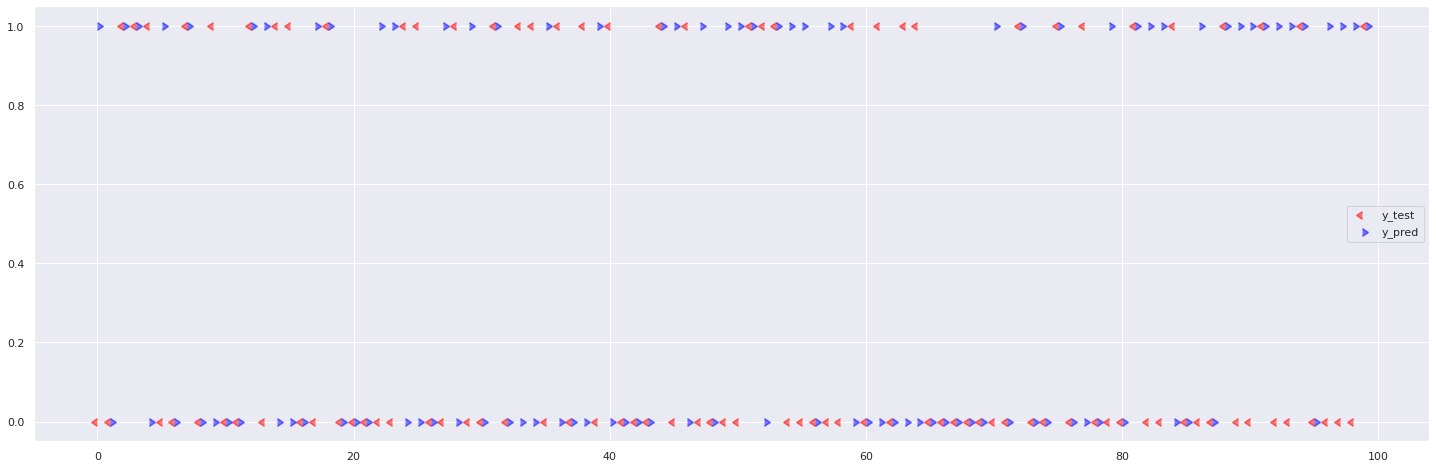

In [22]:
TRUNC = 100 #-1: do not trunc
x = np.linspace(0,y_test.shape[0]-1,y_test.shape[0])
plt.figure(figsize=(25,8))
plt.scatter(x[0:TRUNC],y_pred[0:TRUNC],color='red',alpha=.5, marker=8,s=60, label="y_test")
plt.scatter(x[0:TRUNC],y_test[0:TRUNC],color='blue',alpha=.5, marker=9,s=60, label="y_pred")
plt.legend()